<a href="https://colab.research.google.com/github/Toavina00/adult-uci-ml/blob/main/adult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Census Income

## Description
We want to determine whether a person makes over \\$50,000 a year based on census data. This is a classification problem where we aim to categorize individuals into two groups: those with an income exceeding \\$50,000 annually and those with an income below this threshold. Given that we have a classification task, a machine learning algorithm can be applied to the problem.

To achieve this, we will analyze the "Census Income" dataset containing various features and by leveraging them, we can train a machine learning model to make accurate classifications. This classification task can be useful for applications such as targeted marketing, economic research, and policy-making.

Once the model is trained, we will evaluate its performance using metrics such as accuracy and F1 score. These metrics will help us ensure that our model is reliable and effective in distinguishing between the two income groups.


## Dataset
- Source: https://archive.ics.uci.edu/dataset/2/adult
- Summary: Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0)).

## Data fetching

In [ ]:
import warnings

warnings.simplefilter("ignore")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
adult = fetch_ucirepo(id=2)

# data (as pandas dataframes)
X = adult.data.features
y = adult.data.targets

## Exploratory Data Analysis

In [ ]:
df = pd.concat([X,y], axis=1)

In [ ]:
df.shape

(48842, 15)

Our dataset contains 48,842 observations and 15 features.

In [ ]:
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


The above cell gives us an overview of the first lines of our dataset.

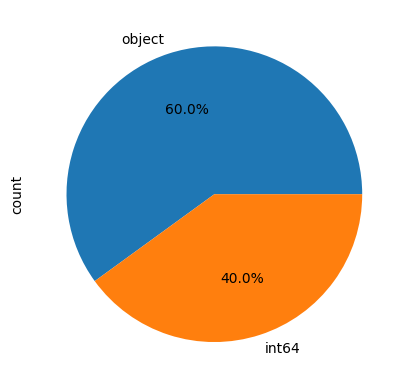

In [ ]:
df.dtypes.value_counts().plot.pie(autopct='%1.1f%%');

As we can see in the pie plot above, 60 % of our features sont de type object et 40 % sont de type int. We only have categorical and discrete numerical variables.

In [ ]:
pd.DataFrame( df.isna().sum() / df.shape[0] ).rename({0: "Missing pct"}, axis=1)

,Missing pct
age,0.000000
workclass,0.019717
fnlwgt,0.000000
education,0.000000
education-num,0.000000
marital-status,0.000000
occupation,0.019778
relationship,0.000000
race,0.000000
sex,0.000000


The above shows us that some of the values from the columns *workclass*, *occupation* and *native-country* are missing.

### Categorical variables

In [ ]:
pd.DataFrame( df.select_dtypes("O").nunique() ).rename({0: "distinct values"}, axis=1)

,distinct values
workclass,9
education,16
marital-status,7
occupation,15
relationship,6
race,5
sex,2
native-country,42
income,4


The table above shows the number of unique values in each categorical variable. Notably, the *native-country*, *education* and *occupation* columns contains a significant number of unique values. Additionally, we observe an issue with the *income* column, which should have only two unique values but instead has four different ones.

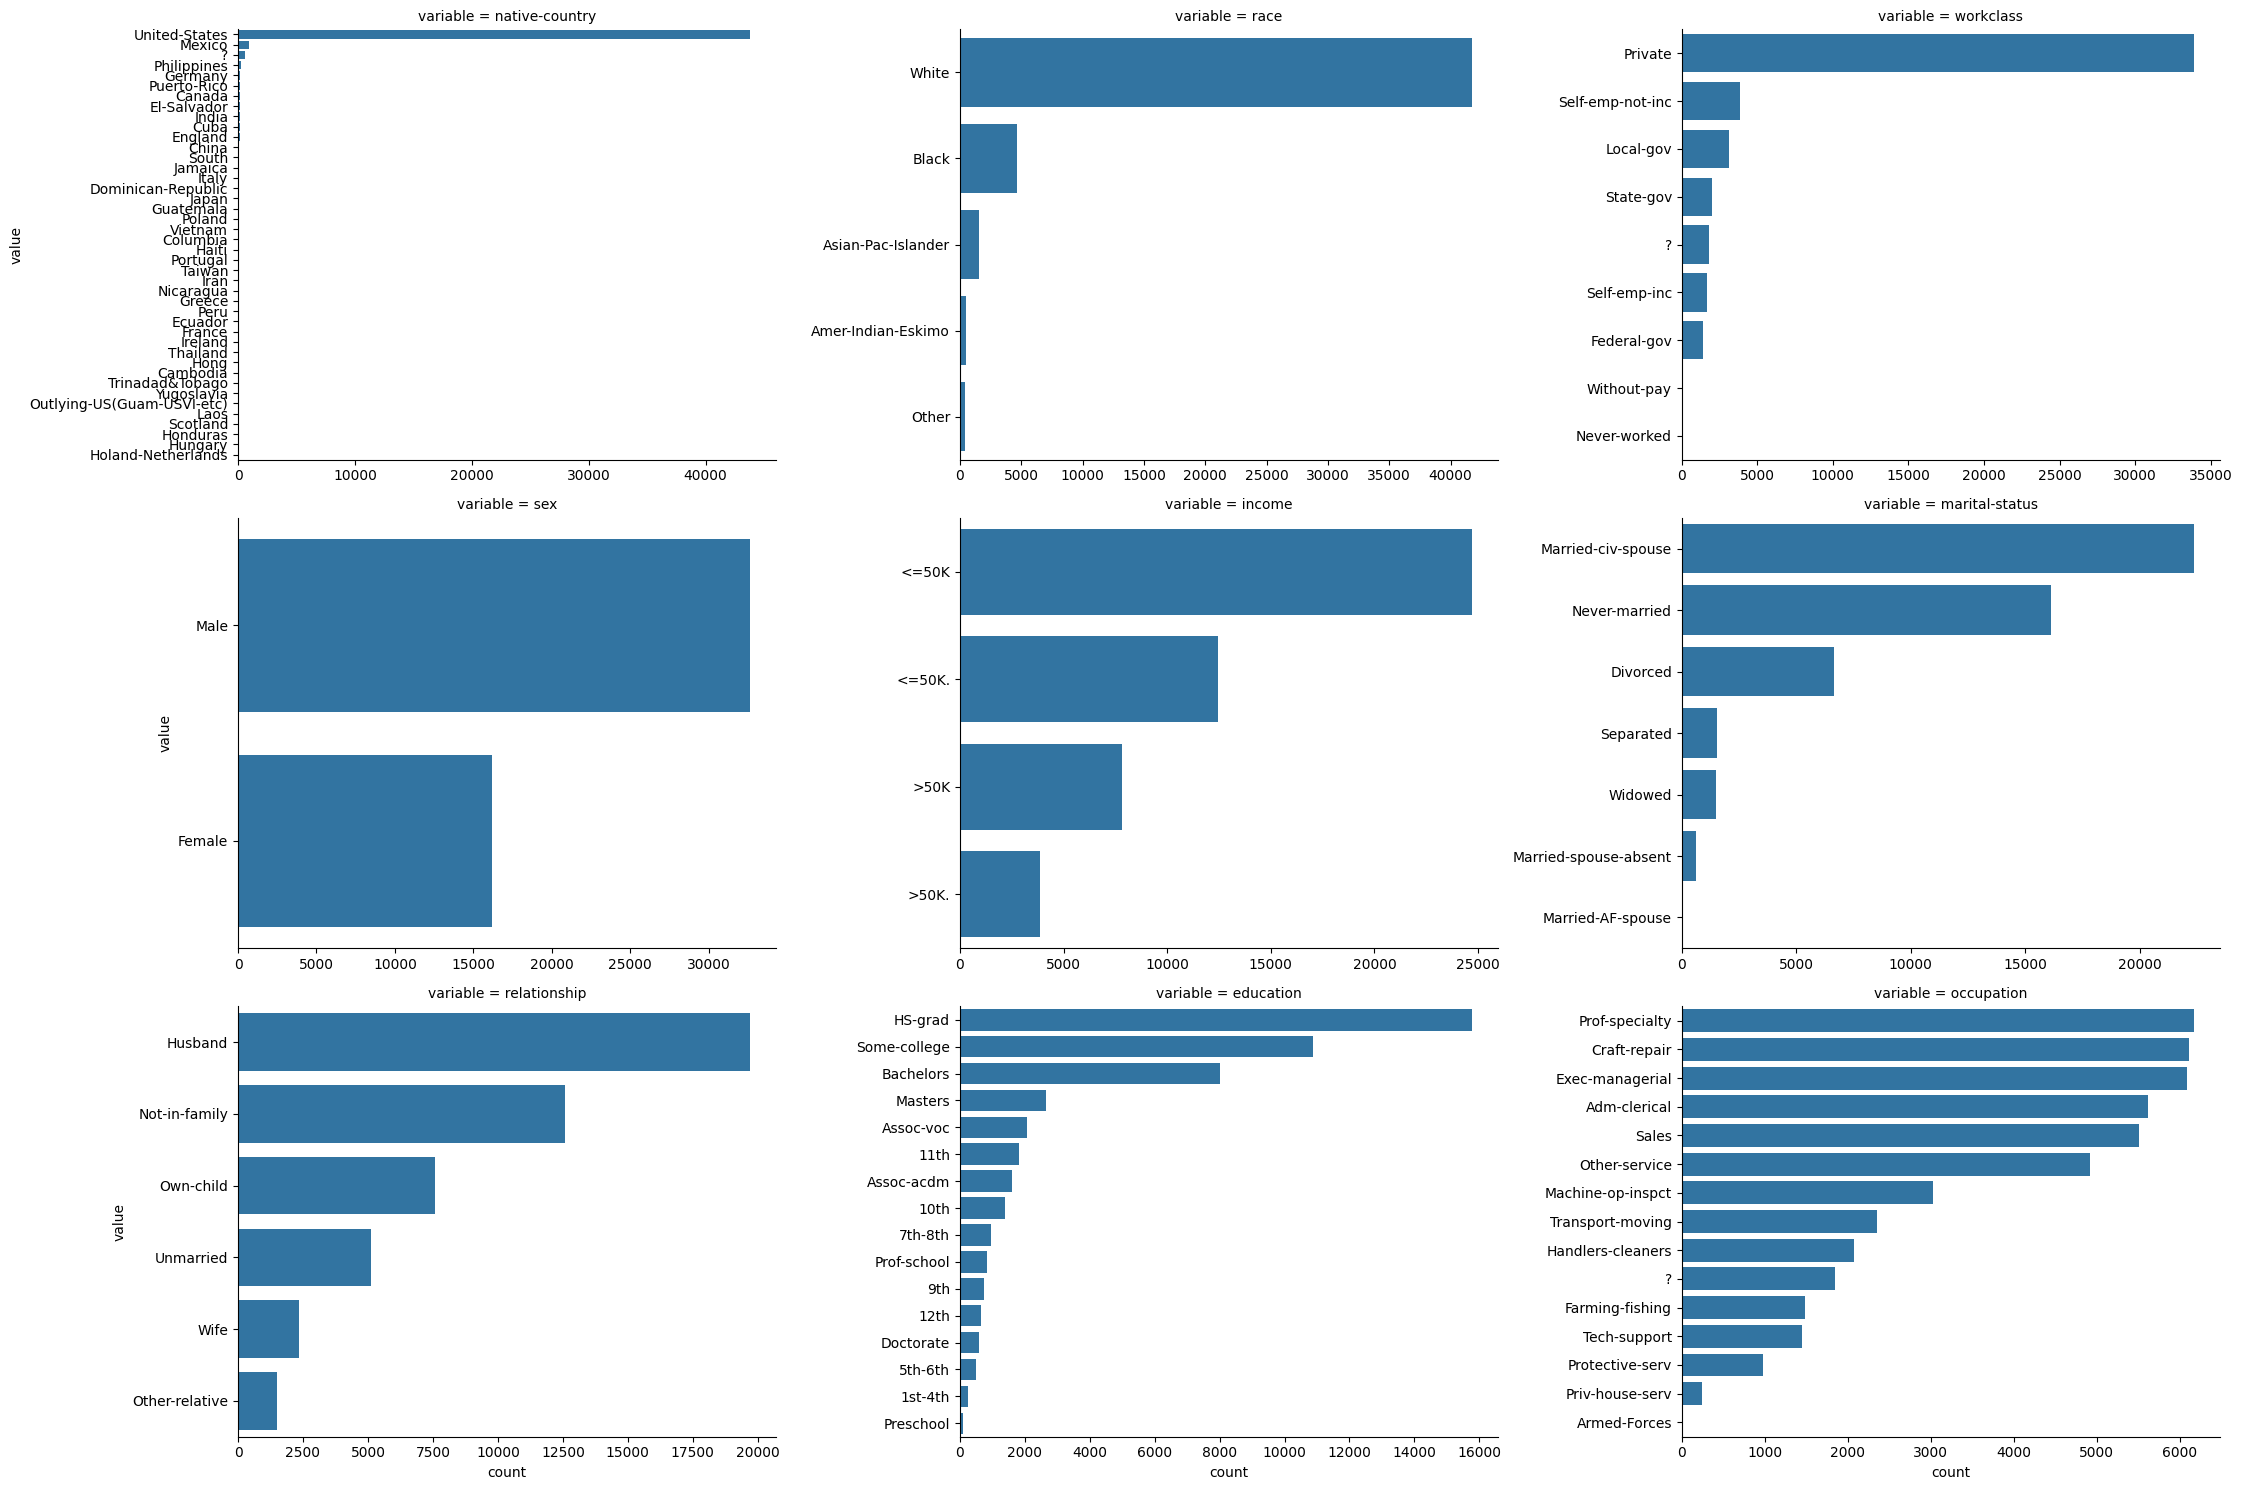

In [ ]:
g = sns.FacetGrid(
    data=df.select_dtypes("O").melt().value_counts().reset_index(),
    col="variable",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1.5,
)
g.map(sns.barplot, "count", "value", orientation="horizontal");

The bar plots above illustrate the distributions of observations for each value within the categorical variables, including the target variable. We observe significant imbalances, particularly in the *native-country*, *race*, and *workclass* variables. These imbalances could potentially bias our model toward the dominant categories, leading to ethical concerns. The *native-country* variable, in particular, is very imbalanced, making it difficult for our data to generalize across all values of *native-country* and adequately represent them.

Regarding the income variable, we observe that there are more than two classes, which does not align with the initially stated target. However, we can merge equivalent classes to achieve the two desired classes.

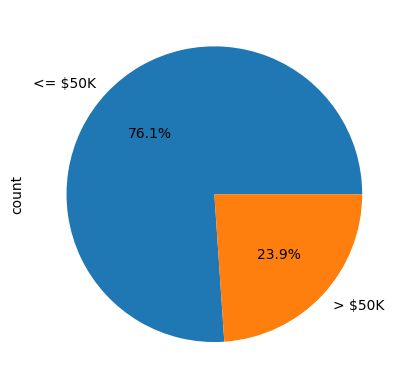

In [ ]:
df["income"].str.replace(r"<=.*", "<= $50K", regex=True).replace(r">.*", "> $50K", regex=True).value_counts().plot.pie(autopct='%1.1f%%');

The pie chart above displays the proportion of the two classes. The classes are imbalanced, with a dominant proportion of individuals having an income of less than 50K.

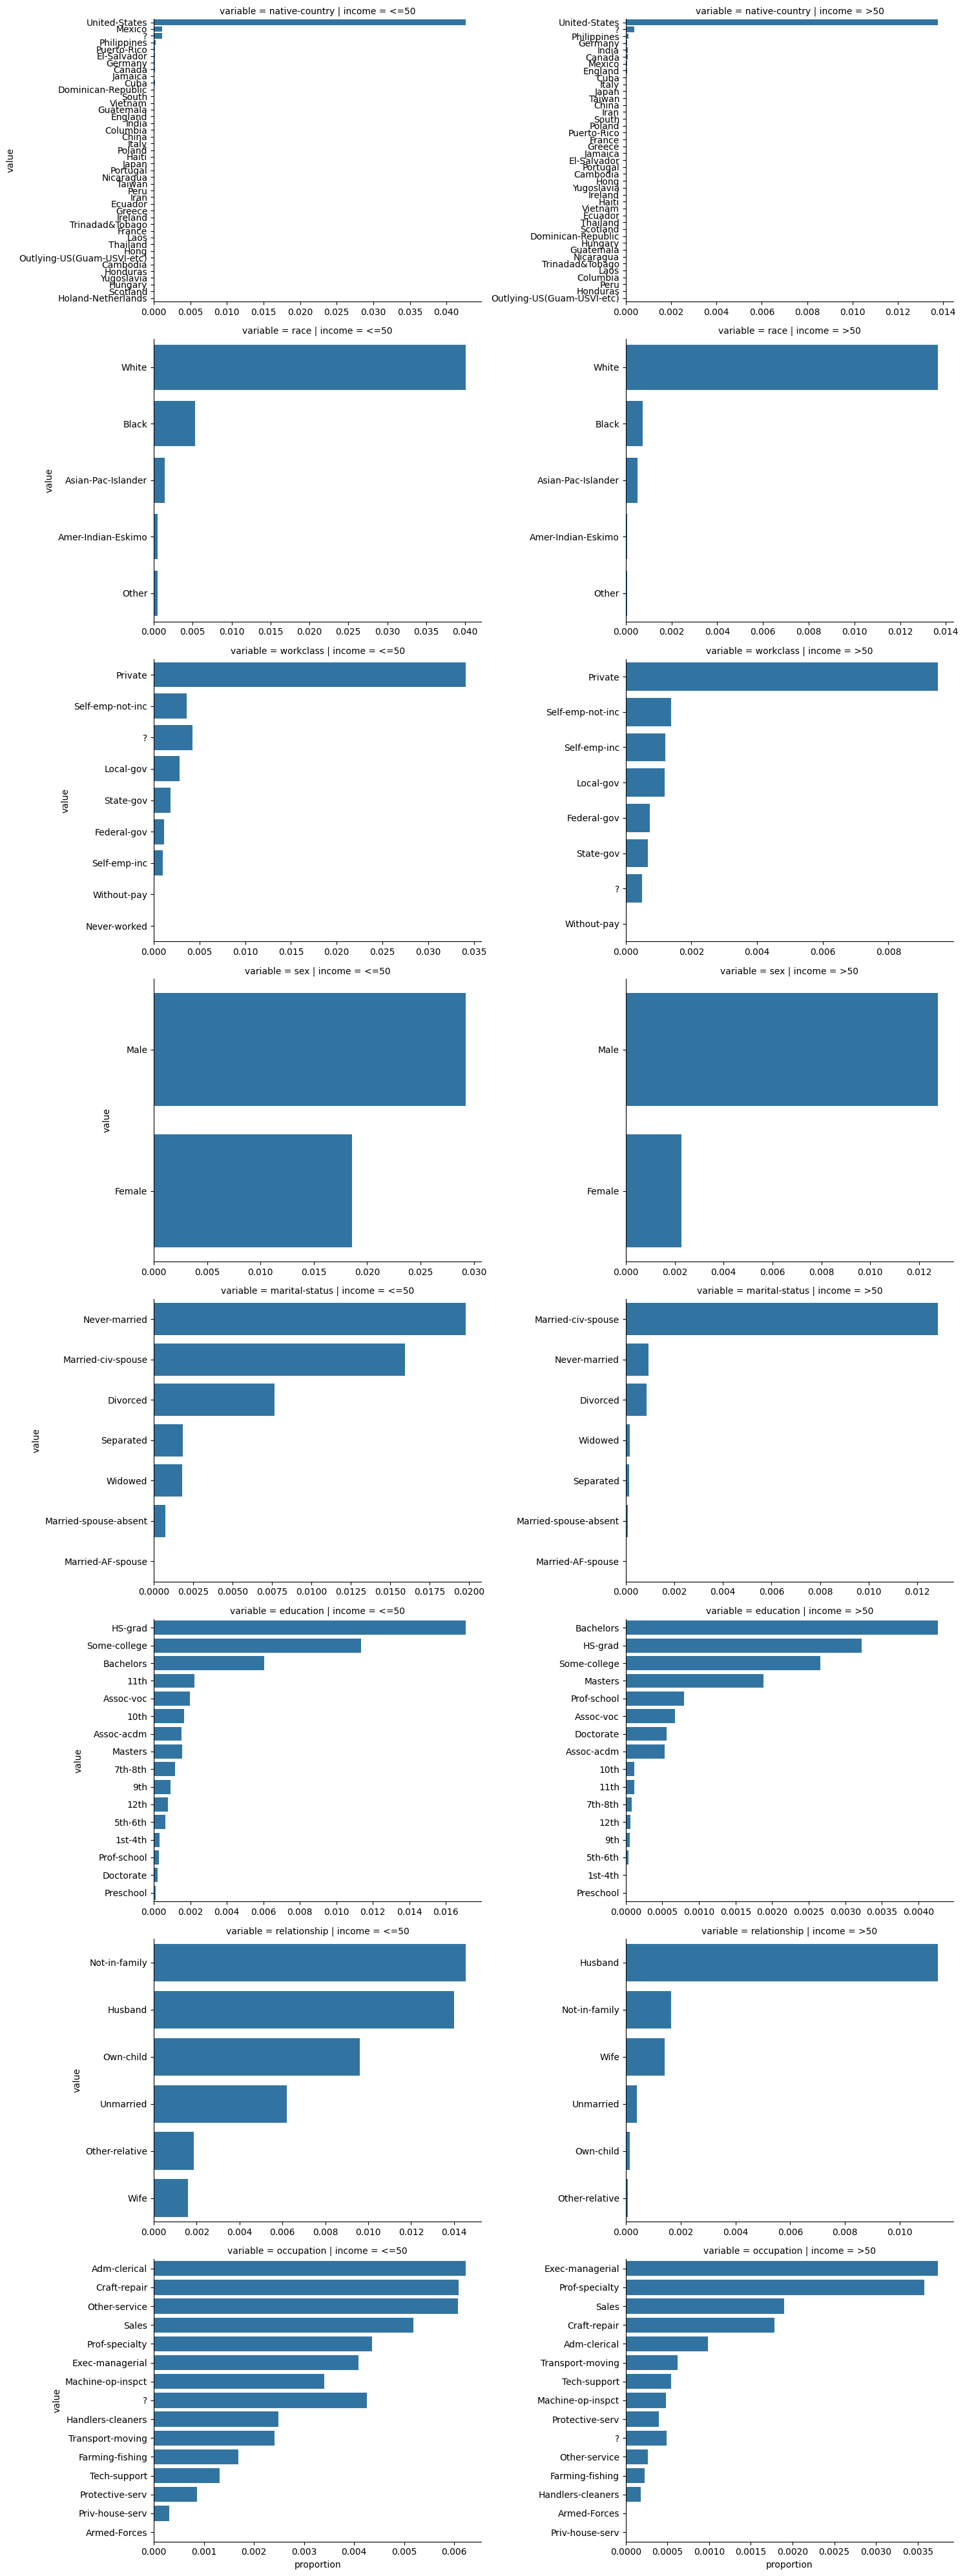

In [ ]:
_d = df.select_dtypes("O").melt(id_vars="income").value_counts(normalize=True).reset_index()
_d["income"] = _d["income"].str.replace(r"<=.*", "<=50", regex=True).replace(r">.*", ">50", regex=True)

g = sns.FacetGrid(
    data=_d,
    row ="variable",
    col = "income",
    sharex=False,
    sharey=False,
    height=5,
    aspect=1.5,
)
g.map(sns.barplot, "proportion", "value", orientation="horizontal", ci=None);

In the plots above, we can see the proportion of each category within each categorical variable across the two classes of income. We can observe that the columns *native-country* and *race* may not provide much information about a person's income because their distributions do not differ much across both classifications. Variables such as *relationship* or *occupation* may contain more important information.

In [ ]:
le = LabelEncoder()

_d = df.select_dtypes("O")
_d["income"] = _d["income"].map(lambda x: 1 if x[0] == '>' else 0)

mi = {}

for col in _d.drop(columns="income").columns:
  _X = le.fit_transform(_d[col])
  mi[col] = mutual_info_classif(_X.reshape(-1, 1), _d.income)

pd.DataFrame(mi).rename({0: "mutual information"}).T.sort_values("mutual information", ascending=False)

,mutual information
marital-status,0.109923
relationship,0.066161
occupation,0.035285
sex,0.035039
education,0.019039
race,0.013166
workclass,0.009686
native-country,0.009308


The results above provide a measure of the relationship between each variable and the target. A higher variable score indicates a stronger relationship with the target.

### Numerical variables

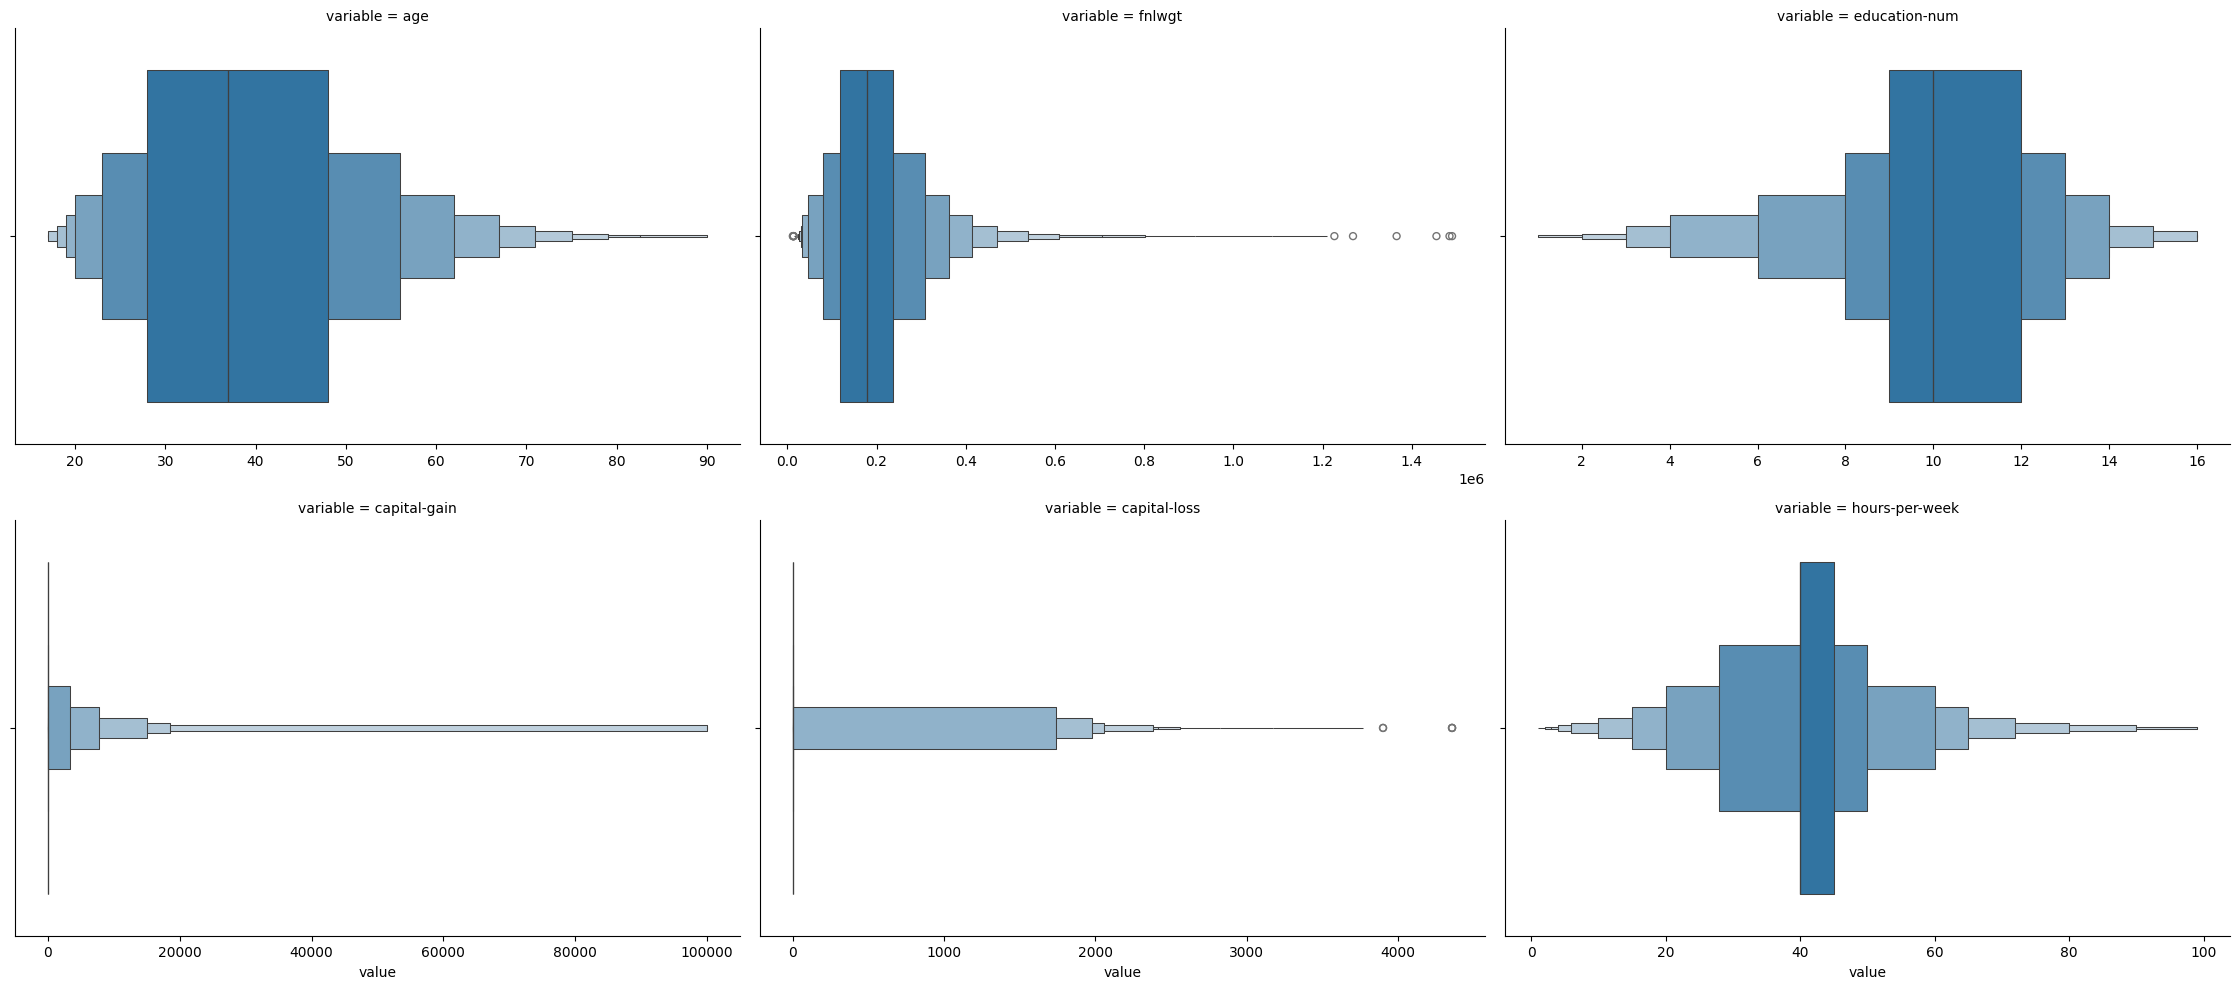

In [ ]:
g = sns.FacetGrid(
    data=df.select_dtypes("int64").melt(),
    col="variable",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1.5,
)

g.map(sns.boxenplot, "value", orient="horizontal");

The chart above displays several violin plots representing the distribution of various numerical variables, indicating the ranges where the majority of the values fall. Most variables appear to be slightly skewed, except for *capital-gain* and *capital-loss*, which are heavily right-skewed with numerous outliers. Additionally, the *fnlwgt* variable also exhibits a few outliers.

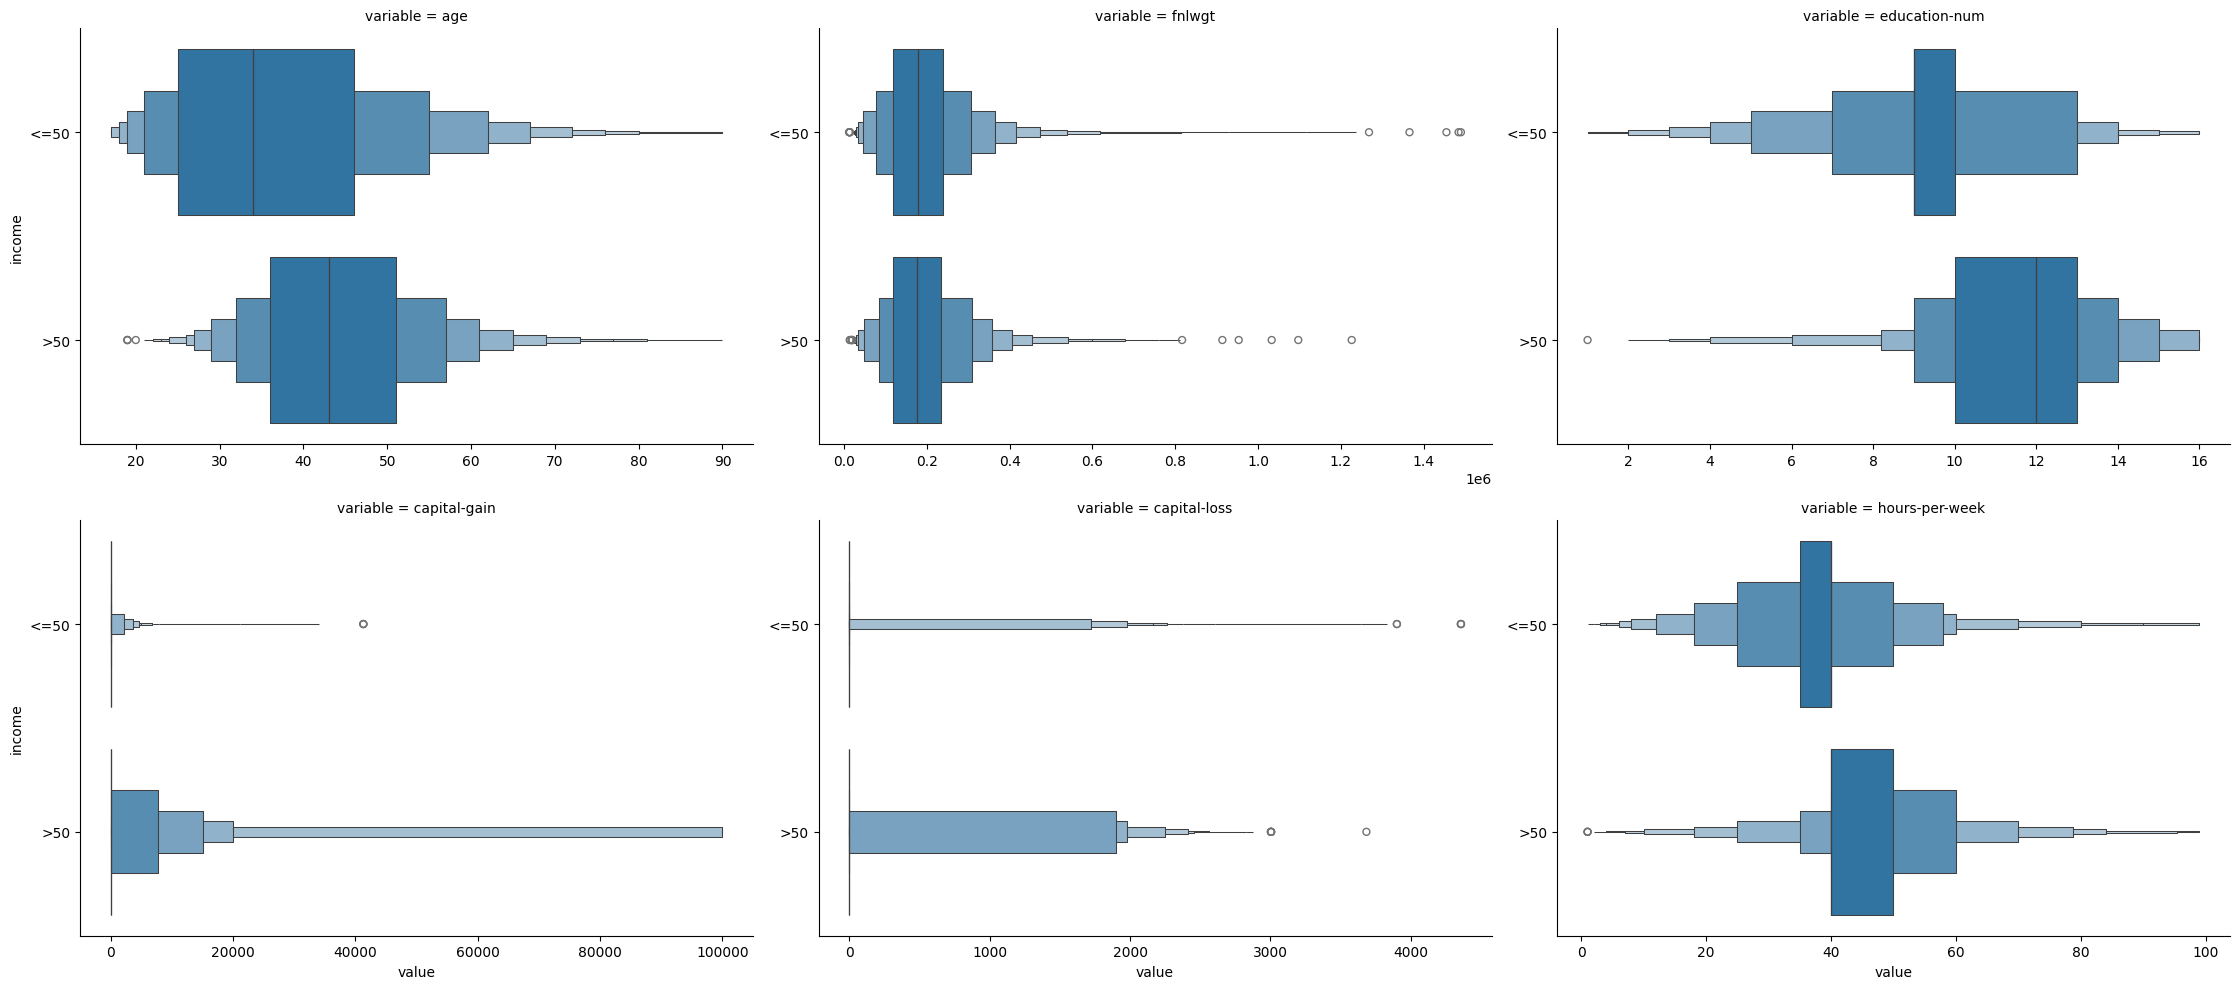

In [ ]:
_d = df.select_dtypes(np.number)
_d = pd.concat([_d, df["income"].str.replace(r"<=.*", "<=50", regex=True).replace(r">.*", ">50", regex=True)], axis=1)

g = sns.FacetGrid(
    data=_d.melt(id_vars="income"),
    col="variable",
    col_wrap=3,
    sharex=False,
    sharey=False,
    height=5,
    aspect=1.5,
)

g.map(sns.boxenplot, "value", "income", orient="horizontal");

The chart above displays several violin plots representing the distribution of different numerical variables across the two classes. Most variables show differing distributions between the classes, suggesting a relationship with the target. However, the *fnlwgt* variable's distribution does not appear to differ significantly across the classes.

In [ ]:
le = LabelEncoder()

_d = df.select_dtypes(np.number)
_d["income"] = df["income"].map(lambda x: 1 if x[0] == '>' else 0)

mi = {}

for col in _d.drop(columns="income").columns:
  mi[col] = mutual_info_classif(_d[col].to_numpy().reshape(-1, 1), _d.income)

pd.DataFrame(mi).rename({0: "mutual information"}).T.sort_values("mutual information", ascending=False)

,mutual information
education-num,0.060048
age,0.058236
capital-gain,0.049067
hours-per-week,0.038281
capital-loss,0.013166
fnlwgt,0.005322


The results above measure the strength of the relationship between each numerical variable and the target. A higher score indicates a stronger relationship with the target.

## Model

In [51]:
import sklearn
sklearn.set_config(transform_output="pandas")

In [ ]:
!pip install category_encoders

In [55]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin

In [50]:
data = pd.concat([X,y], axis=1)
data.income = data.income.map(lambda x: 1 if x[0] == '>' else 0)

In [29]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

#### Baseline

First, we will establish a baseline for all subsequent models.

In [ ]:
df_train, df_val = train_test_split(train.select_dtypes(np.number), test_size=0.2, random_state=42)

X_train, y_train = df_train.drop(columns="income"), df_train.income
X_val, y_val = df_val.drop(columns="income"), df_val.income

model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"F1 score: {f1_score(y_val, y_pred)}")

Accuracy: 0.7925783749200256
F1 score: 0.37533718689788054


We will now experiment with various models using different feature engineering approaches.

#### Logistic Regression
**features**: Numerical features + Standard Scaler

In [30]:
df_train, df_val = train_test_split(train.select_dtypes(np.number), test_size=0.2, random_state=42)

X_train, y_train = df_train.drop(columns="income"), df_train.income
X_val, y_val = df_val.drop(columns="income"), df_val.income

preprocessing = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number))
)

model = LogisticRegression()

pipe = make_pipeline(preprocessing, model)

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_val)

print(f"Accuracy: {accuracy_score(y_val, y_pred)}")
print(f"F1 score: {f1_score(y_val, y_pred)}")

Accuracy: 0.8085732565579015
F1 score: 0.489419795221843


#### Random Forest Classifier
**features**: Numerical features

In [44]:
df_train = train.select_dtypes(np.number)

X_train, y_train = df_train.drop(columns="income"), df_train.income

model = RandomForestClassifier(random_state=42)

gsc = GridSearchCV(
    model,
    param_grid = {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20],
    },
    cv=5,
    scoring="f1",
    n_jobs=-1,
)

gsc.fit(X_train, y_train)

best_model = gsc.best_estimator_

print(f"Best params: {gsc.best_params_}")
print(f"Accuracy: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy').mean()}")
print(f"F1 score: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1').mean()}")

Best params: {'max_depth': 20, 'n_estimators': 50}
Accuracy: 0.831853062919533
F1 score: 0.5708746957141787


#### Logistic Regression with Regularization
**features**: Numerical features + feature selection + standard scaler

In [45]:
df_train = train.select_dtypes(np.number)

X_train, y_train = df_train.drop(columns="income"), df_train.income

preprocessing = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number))
)

model = LogisticRegression()

pipe = make_pipeline(preprocessing, SelectKBest(score_func=mutual_info_classif), model)

gsc = GridSearchCV(
    pipe,
    param_grid = {
        "selectkbest__k": [3,4,5,6],
        "logisticregression__C": [0.1, 1, 10]
    },
    cv=5,
    scoring="f1",
    n_jobs=-1,
)

gsc.fit(X_train, y_train)

best_model = gsc.best_estimator_

print(f"Best params: {gsc.best_params_}")
print(f"Accuracy: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy').mean()}")
print(f"F1 score: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1').mean()}")

Best params: {'logisticregression__C': 10, 'selectkbest__k': 6}
Accuracy: 0.8148081310167079
F1 score: 0.49764459992032084


#### Random Forest Classifier
**features**: Numerical features + feature selection

In [46]:
df_train = train.select_dtypes(np.number)

X_train, y_train = df_train.drop(columns="income"), df_train.income

model = RandomForestClassifier(random_state=42)

pipe = make_pipeline(SelectKBest(score_func=mutual_info_classif), model)

gsc = GridSearchCV(
    pipe,
    param_grid = {
        "selectkbest__k": [3,4,5,6],
        "randomforestclassifier__n_estimators": [50, 100, 200],
        "randomforestclassifier__max_depth": [5, 10, 20],
    },
    cv=5,
    scoring="f1",
    n_jobs=-1,
)

gsc.fit(X_train, y_train)

best_model = gsc.best_estimator_

print(f"Best params: {gsc.best_params_}")
print(f"Accuracy: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy').mean()}")
print(f"F1 score: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1').mean()}")

Best params: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 50, 'selectkbest__k': 6}
Accuracy: 0.831853062919533
F1 score: 0.5708746957141787


#### Logistic Regression

In [56]:
class CustomTargetEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.encoder = None
    self.fitted = False

  def fit(self, X, y):
    if self.fitted: return self
    self.encoder = TargetEncoder()
    self.encoder.fit(X, y)
    self.fitted = True
    return self

  def transform(self, X):
    return self.encoder.transform(X)

In [66]:
df_train = train.copy()

X_train, y_train = df_train.drop(columns=["income", "native-country"]), df_train.income

preprocessing = make_column_transformer(
    (StandardScaler(), make_column_selector(dtype_include=np.number)),
    (CustomTargetEncoder(), make_column_selector(dtype_include="O")),
)

model = LogisticRegression()

pipe = make_pipeline(preprocessing, SelectKBest(score_func=mutual_info_classif), model)

gsc = GridSearchCV(
    pipe,
    param_grid = {
        "selectkbest__k": [6,8,10,11,12,13],
        "logisticregression__C": [0.1, 1, 10]
    },
    cv=5,
    scoring="f1",
    n_jobs=-1,
)

gsc.fit(X_train, y_train)

best_model = gsc.best_estimator_

print(f"Best params: {gsc.best_params_}")
print(f"Accuracy: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy').mean()}")
print(f"F1 score: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1').mean()}")


Best params: {'logisticregression__C': 10, 'selectkbest__k': 10}
Accuracy: 0.8478743846248697
F1 score: 0.6451156821596252


#### Random Forest Classifier

In [67]:
class IdentityTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X


In [68]:
class CustomTargetEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.encoder = None
    self.fitted = False

  def fit(self, X, y):
    if self.fitted: return self
    self.encoder = TargetEncoder()
    self.encoder.fit(X, y)
    self.fitted = True
    return self

  def transform(self, X):
    return self.encoder.transform(X)

In [69]:
df_train = train.copy()

X_train, y_train = df_train.drop(columns=["income", "native-country"]), df_train.income

preprocessing = make_column_transformer(
    (IdentityTransformer(), make_column_selector(dtype_include=np.number)),
    (CustomTargetEncoder(), make_column_selector(dtype_include="O")),
)

model = RandomForestClassifier(random_state=42)

pipe = make_pipeline(preprocessing, SelectKBest(score_func=mutual_info_classif), model)

gsc = GridSearchCV(
    pipe,
    param_grid = {
        "selectkbest__k": [6,8,10,11,12,13],
        "randomforestclassifier__n_estimators": [50, 100, 200],
        "randomforestclassifier__max_depth": [5, 10, 20],
    },
    cv=5,
    scoring="f1",
    n_jobs=-1,
)

gsc.fit(X_train, y_train)

best_model = gsc.best_estimator_

print(f"Best params: {gsc.best_params_}")
print(f"Accuracy: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy').mean()}")
print(f"F1 score: {cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1').mean()}")

Best params: {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 200, 'selectkbest__k': 12}
Accuracy: 0.8653800739227998
F1 score: 0.6884113972805521


#### Best model

After testing several models with different strategies, we identified the following best-performing model.

In [71]:
class IdentityTransformer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X

class CustomTargetEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.encoder = None
    self.fitted = False

  def fit(self, X, y):
    if self.fitted: return self
    self.encoder = TargetEncoder()
    self.encoder.fit(X, y)
    self.fitted = True
    return self

  def transform(self, X):
    return self.encoder.transform(X)

In [72]:
df_train = train.copy()

X_train, y_train = df_train.drop(columns=["income", "native-country"]), df_train.income

preprocessing = make_column_transformer(
    (IdentityTransformer(), make_column_selector(dtype_include=np.number)),
    (CustomTargetEncoder(), make_column_selector(dtype_include="O")),
)

model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)

pipe = make_pipeline(preprocessing, SelectKBest(score_func=mutual_info_classif, k=12), model)

pipe.fit(X_train, y_train)

X_test, y_test = test.drop(columns=["income", "native-country"]), test.income

y_pred = pipe.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 score: {f1_score(y_test, y_pred)}")

Accuracy: 0.8633432285802027
F1 score: 0.6704517403110344


---